In [3]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import json
% matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import configparser 
config = configparser.ConfigParser()
config.read('config.ini')
ip = config['DEFAULT']['IP']
port = config['DEFAULT']['MongoDB-Port']

from pymongo import MongoClient
client = MongoClient(ip, int(port))

In [4]:
def generate_word_cloud(collection_name):
    
    # aggregate by tags and sum, sort by count
    
    tag_counts = list(client['Twitter'][collection_name].aggregate([
        {"$match": {"entities.hashtags": {"$ne": []}}},
        {"$unwind": "$entities.hashtags"},
        {"$group": {
            "_id": "$entities.hashtags.text",
            "count": {"$sum": 1}
        }},
        {"$match": {"count": {"$gt": 50}}} # only tags with 50+ appearances
    ], allowDiskUse=True))
    
    # generate tag frequency dict
    
    frequencies = {}
    for item in tag_counts:
        tag = item['_id']
        count = item['count']
        frequencies[tag] = count
        
    # create cloud and output image
    
    wordcloud = WordCloud(width=800, height=400, max_words=100, background_color="white")
    wordcloud.generate_from_frequencies(frequencies=frequencies)

    plt.figure(figsize=(16,8)).suptitle(collection_name, fontsize=30)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
    file_name = 'output/' + collection_name + '-tag-cloud.png'
    wordcloud.to_file(file_name)

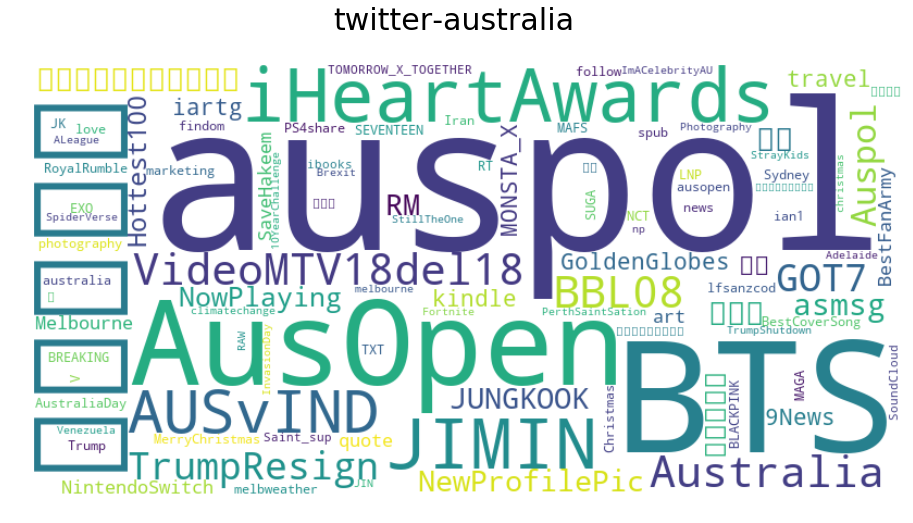

In [5]:
generate_word_cloud('twitter-australia')

In [ ]:
generate_word_cloud('twitter-other')